# CEO-Request Challenge

## 1. Summary of Problem Statement

❓ **How can Olist increase its profit?** ❓

### P&L Rules

#### Revenues
**Sales fees:** Olist takes a **10% share** on the product price (excluding freight) of every delivered order.  
**Subscription fees:** Olist charges **80 BRL per month** per seller.

#### Costs
Estimated **reputation costs** for orders with poor reviews (<= 3 stars)  

💡 In the long term, poor customer experience leads to business consequences: low repeat purchase rate, immediate customer support costs, refunds, or negative word-of-mouth communication. We assume a monetary cost for each bad review:

```python
# review_score: cost(BRL)
{'1 star': 100
'2 stars': 50
'3 stars': 40
'4 stars': 0
'5 stars': 0}
```

**IT costs:** Olist's total cumulated IT costs scale in proportion to the square root of the total number of sellers that have joined the platform so far and the square root of the total cumulative number of items sold.

$IT\_costs = \alpha * \sqrt{n\_sellers} + \beta * \sqrt{n\_items}$  

Olist's data team provided us with the following values for these scaling parameters:
- $\alpha = 3157.27$
- $\beta = 978.23$

💡 Both the number of sellers managed and the number of sales transactions are costly for IT systems.
💡 However, the use of square root shows scale-effects: IT systems tend to become more efficient as they grow.
💡 The fact that Alpha > Beta means that Olist has lower IT costs when working with fewer sellers selling many items compared to the opposite scenario.

With 1000 sellers and total sales of 100 items, the total IT cost is 109,624 BRL

With 100 sellers and total sales of 1000 items, the total IT cost is 62,507 BRL

Finally, the IT department also informed us that the total accumulated IT costs since the marketplace's founding is 500,000 BRL.

Now, let's run a simulation to better understand this IT cost formula. You don't need to spend time on the code, just look at the resulting charts.

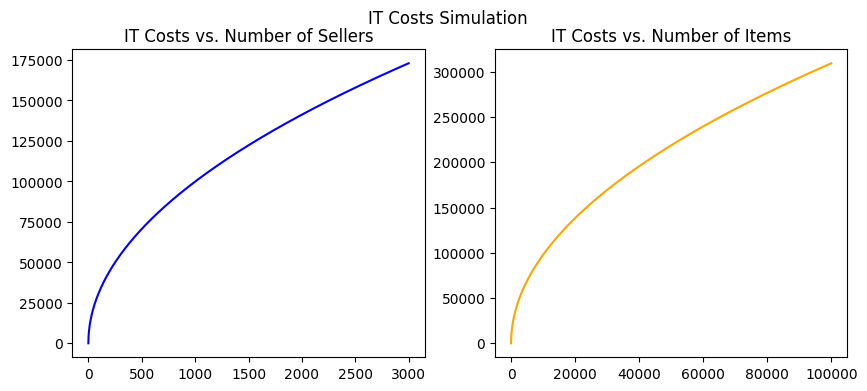

In [4]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

alpha = 3157.27
beta = 978.23

x_sellers = np.arange(3_000)
y_it_costs_sellers = alpha * x_sellers ** 0.5

x_items = np.arange(100_000)
y_it_costs_items = beta * x_items ** 0.5

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(x_sellers, y_it_costs_sellers, label='IT costs per seller', color='blue')
plt.title('IT Costs vs. Number of Sellers')
plt.subplot(1, 2, 2)
plt.plot(x_items, y_it_costs_items, label='IT costs per item', color='orange')
plt.title('IT Costs vs. Number of Items')
plt.suptitle('IT Costs Simulation');

### Key Findings So Far

- `wait_time` is the most important factor behind low review scores.  
- `wait_time` consists of the seller's `delay_to_carrier` time + `carrier_delivery_time`.  
- Since the carrier's delivery time is not directly under Olist's control, improving it is not a quick-win recommendation.  
- On the other hand, better `seller` selection can positively impact the `delay_to_carrier` value and reduce the number of poor `review_scores` on Olist.  
- Comments in poor reviews show that some stem from the seller or the product itself.

## 2. Should Olist Remove Underperforming Sellers from Its Marketplace? 🕵🏻
*(recommended)*

We will conduct a **what-if analysis** to analyze the impact of removing the worst sellers from Olist's marketplace.

👉 **What would have happened if Olist had never accepted these sellers in the first place?**  

*(In reality, it's hard to know upfront who will be a good seller, but we'll start with this approach and iterate later.)*



### 2.1 Data Preparation

For each `seller_id`, calculate cumulatively from the beginning:
- the `revenues` generated by the seller
- the `review_costs` associated with the seller's bad reviews
- the resulting `profits` (revenues - costs)

👉 Write a step-by-step strategy to create the DataFrame you need.

⚠️ **Don't start from scratch, update your existing package!** 😉

**The solution is not about writing new code in the notebook — it's about modifying the code in your `.py` files.**

Starting from the `Seller` class in your `olist` package:

Modify the `get_training_data` method; the DataFrame it returns should include these fields:
- `revenues`: sum of subscription + sales fees  
- `cost_of_reviews`: total cost associated with bad reviews  
- `profits`: `revenues` - `cost_of_reviews`

For `cost_of_reviews`, you'll need to modify another method first. Which method is related to this?

### 2.2 Scenario Analysis Excluding IT Costs


👉 Time to conduct the real analysis. First, we'll do this **without including** IT costs.

Our steps:  

1️⃣ Load the sellers data and sort it in descending order by profit value.

2️⃣ Calculate cumulative values:
   - Calculate cumulative revenues for each row.
   - Calculate cumulative profits for each row.
   - Calculate cumulative items sold for each row.

   Research how to calculate cumulative sum with Pandas.

3️⃣ Plot and analyze your results. Use Pandas' `.plot()` method.

4️⃣ Determine the optimal number of sellers to keep based on profits. (Hint: look up `np.argmax`). What would be the impact of this decision:
   - Net profit (pre-IT costs since we're not including IT costs)?
   - Total revenues?
   - Number of sellers?
   - Number of items sold?

In [5]:
import sys
sys.path.append('../')

In [6]:
from olist.seller_updated import Seller
seller = Seller()
sellers = seller.get_training_data()
sellers_sorted = sellers.sort_values(by='profits', ascending=False)

/Users/yaren/code/ds_projects/sprint-15/data-olist-ceo-request/../olist/seller_updated.py:68: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(delay_to_logistic_partner)\
/Users/yaren/code/ds_projects/sprint-15/data-olist-ceo-request/../olist/seller_updated.py:73: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(order_wait_time)\


In [7]:
metrics_ordered = sellers[['revenues', 'cost_of_reviews', 'profits', 'quantity']] \
                  .sort_values(by='profits', ascending=False) \
                  .reset_index().drop(columns='index')
metrics_ordered.cost_of_reviews *= -1
metrics_ordered['n_sellers'] = 1
metrics_ordered

,revenues,cost_of_reviews,profits,quantity,n_sellers
0,23237.605,-5170.0,18067.605,410,1
1,19323.187,-4700.0,14623.187,340,1
2,21004.203,-6510.0,14494.203,586,1
3,8808.455,-1520.0,7288.455,175,1
4,14651.119,-7500.0,7151.119,542,1
...,...,...,...,...,...
2962,2553.569,-15440.0,-12886.431,1018,1
2963,4677.752,-20220.0,-15542.248,1203,1
2964,11948.842,-28840.0,-16891.158,1775,1
2965,21647.292,-38970.0,-17322.708,1987,1


<Axes: >

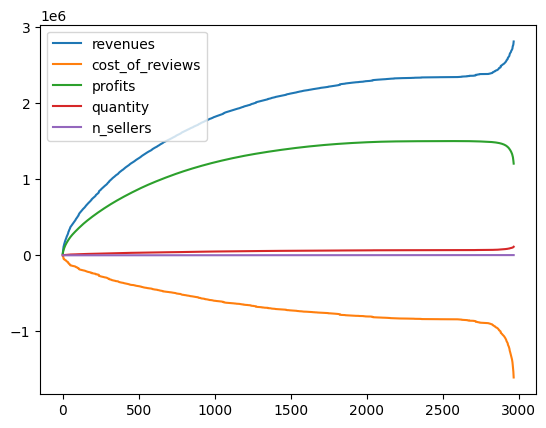

In [8]:
metrics_cumulative = metrics_ordered.cumsum()
metrics_cumulative.plot()

In [9]:
optimum_without_it = metrics_cumulative.profits.argmax()
optimum_without_it

2601

,impact
revenues,-466802.492
cost_of_reviews,762990.000
profits,296187.508
quantity,-44471.000
n_sellers,-365.000


<Axes: title={'center': 'Impact of removing the worst sellers - without IT costs'}>

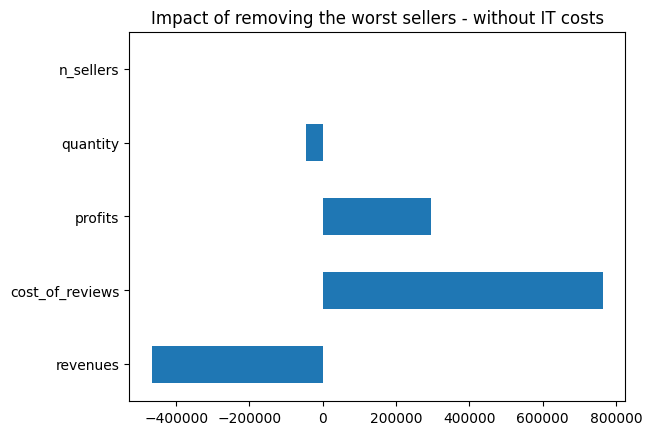

In [10]:
# Calculating the impact of removing the worst sellers
impact_without_it_costs = metrics_cumulative.iloc[optimum_without_it] - metrics_ordered.sum()
display(pd.DataFrame(impact_without_it_costs, columns=["impact"]))
impact_without_it_costs.plot(kind='barh', title="Impact of removing the worst sellers - without IT costs")

## 3. Explore Other Approaches 🕵️
*(optional)*

- Should Olist completely remove the worst-performing products/categories from its marketplace?
- After a few months of honeymoon period, should Olist only remove consistently underperforming sellers?
- Should Olist require sellers to include certain information in their product listings?
- Should Olist request purchase confirmation from customers at certain times of day?
- Should Olist restrict seller/customer pairs between certain states to prevent delays?
- Should Olist acquire new sellers by proposing revised cost assumptions?
- ...

# Olist Overview

## 1. Prepare

In [11]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
from plotly.offline import init_notebook_mode
from IPython.display import Markdown as md

In [12]:
from olist.seller_updated import Seller
seller = Seller()
sellers = seller.get_training_data()    

/Users/yaren/code/ds_projects/sprint-15/data-olist-ceo-request/../olist/seller_updated.py:68: FutureWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.

/Users/yaren/code/ds_projects/sprint-15/data-olist-ceo-request/../olist/seller_updated.py:73: FutureWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.



In [13]:
sellers.head()

,seller_id,seller_city,seller_state,delay_to_carrier,wait_time,date_first_sale,date_last_sale,months_on_olist,n_orders,quantity,quantity_per_order,sales,share_of_one_stars,share_of_five_stars,review_score,cost_of_reviews,revenues,profits
0,3442f8959a84dea7ee197c632cb2df15,campinas,SP,0.000000,13.018588,2017-05-05 16:25:11,2017-08-30 12:50:19,4.0,3,3,1.000,218.70,0.333333,0.333333,3.00,140.0,341.870,201.870
1,d1b65fc7debc3361ea86b5f14c68d2e2,mogi guacu,SP,0.000000,9.065716,2017-03-29 02:10:34,2018-06-06 20:15:21,14.0,40,41,1.025,11703.07,0.050000,0.725000,4.55,240.0,2290.307,2050.307
2,ce3ad9de960102d0677a81f5d0bb7b2d,rio de janeiro,RJ,0.000000,4.042292,2018-07-30 12:44:49,2018-07-30 12:44:49,0.0,1,1,1.000,158.00,0.000000,1.000000,5.00,0.0,15.800,15.800
3,c0f3eea2e14555b6faeea3dd58c1b1c3,sao paulo,SP,0.000000,5.667187,2018-08-03 00:44:08,2018-08-03 00:44:08,0.0,1,1,1.000,79.99,0.000000,1.000000,5.00,0.0,7.999,7.999
4,51a04a8a6bdcb23deccc82b0b80742cf,braganca paulista,SP,3.353727,35.314861,2017-11-14 12:15:25,2017-11-14 12:15:25,0.0,1,1,1.000,167.99,1.000000,0.000000,1.00,100.0,16.799,-83.201


## 2. Financial Status

### Revenues

In [19]:
revenues_sales = sellers['revenues'].sum() * 0.1
revenues_subscription = sellers['cost_of_reviews'].sum() * 0.8
revenues_total = sellers['revenues'].sum()

print(
    f'''
Revenues: {revenues_total:.2f} BRL
- Sales: {revenues_sales:.2f} BRL
- Subscriptions: {revenues_subscription:.2f} BRL
''')


Revenues: 2807418.44 BRL
- Sales: 280741.84 BRL
- Subscriptions: 1283072.00 BRL



### Costs

In [33]:
costs_reviews = sellers['cost_of_reviews'].sum()
costs_it = 500_000
costs_total = cost_reviews + cost_it

print(
    f'''
Costs: {costs_total:.2f} BRL
- Reviews: {costs_reviews:.2f} BRL
- IT: {costs_it:.2f} BRL
''')


Costs: 2103840.00 BRL
- Reviews: 1603840.00 BRL
- IT: 500000.00 BRL



### Profits

In [29]:
# Gross profit before IT costs
gross_profit = sellers['profits'].sum()
gross_profit


1203578.4440000001

In [31]:
# Gross profit after IT costs
gross_profit_after_it = gross_profit - cost_it
gross_profit_after_it

703578.4440000001

In [34]:
init_notebook_mode(connected=True)

fig = go.Figure(go.Waterfall(
    orientation = "v",
    measure = ["relative", "relative", "total", "relative", "total", "relative", "total"],
    x = ["Monthly subcriptions", "Sales fees", "Total Revenues", "Reviews costs", "Gross Profit", "It costs", "Net Profit"],
    textposition = "outside",
#    text = ["", "+80", "", "-40", "-20", "Total"],
    y = [revenues_subscription, revenues_sales, 0, -costs_reviews, 0,-costs_it, 0],
    connector = {"line":{"color":"rgb(63, 63, 63)"}},
))

fig.update_layout(
        title = {'text': "Olist Profit & Loss (BRL)",
                 'yanchor': 'top',
                 'xanchor': 'left',
                 'xref': 'paper',
                 'font': {'size': 36}},
        showlegend = False
)

fig.show()

### Low Performance Sellers

In [36]:
# Total number of sellers
n_sellers = sellers.shape[0]
# Number of sellers with negative profits
n_negative = sellers.query('profits <= 0').shape[0]
# % of sellers with negative profits
pct_negative = n_negative / n_sellers
# Mean and median of sellers'profits
mean, med = sellers.profits.mean(), sellers.profits.median()
# .25 quantile
q25 = sellers.profits.quantile(q=.25)
# Min, Max of sellers'profits
min_, max_ = sellers.profits.min(), sellers.profits.max()

In [37]:
n_sellers, n_negative, pct_negative, mean, med, q25, min_, max_

(2967,
 365,
 0.12301988540613414,
 405.6550198854062,
 259.0,
 22.180000000000003,
 -21349.517,
 18067.605)

In [38]:
STYLES = {
    'title': {'size': 24, 'color': '#1f77b4'},
    'labels': {'size': 18},
    'text': {'size': 16},
    'legend': {'size': 14},
    'ticks': {'size': 12}
}

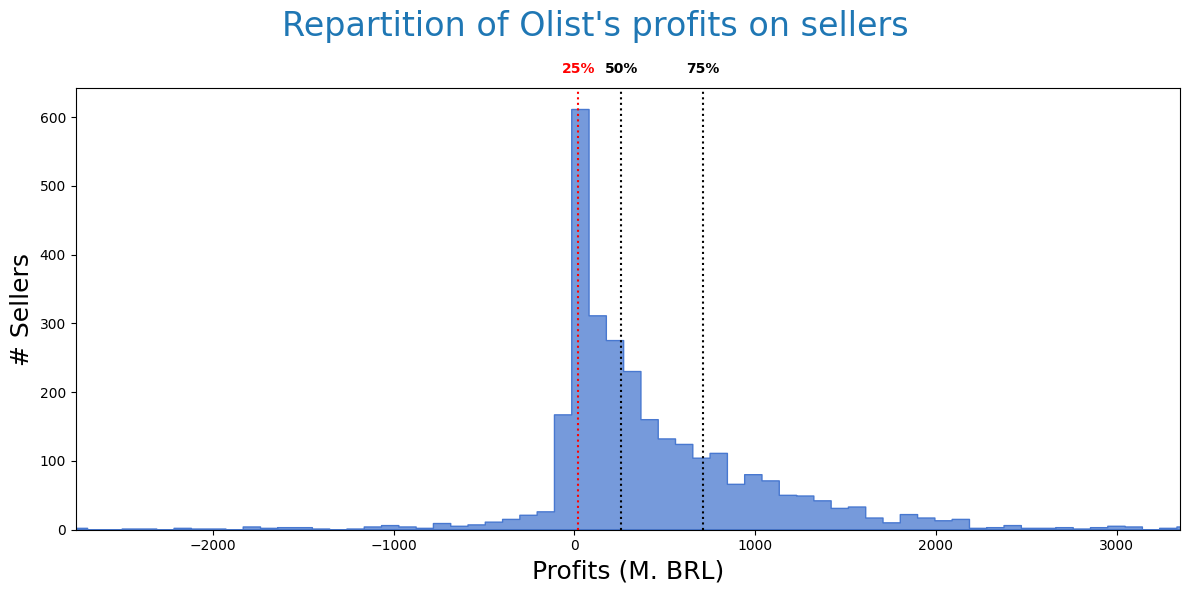

In [39]:
sns.set_palette('muted')

fig, ax = plt.subplots(figsize=(12, 6))

plt.suptitle(t="Repartition of Olist's profits on sellers",
             **STYLES['title'])

sns.histplot(sellers.profits,
             stat='count',
             element='step',
             ax=ax)

quantiles = sellers.profits.quantile(q=[.01, .25, .5, .75, .99])

ax.set_xlim(quantiles.iloc[0], quantiles.iloc[-1])
ax.set_xlabel(xlabel='Profits (M. BRL)',
              fontdict=STYLES['labels'])
ax.set_ylabel(ylabel='# Sellers',
              fontdict=STYLES['labels'])

for p, q in quantiles.iloc[1:-1].items():
    c_ = 'black'
    if p == .25:
        c_ = 'red'
    ax.axvline(x=q,
               color=c_,
               ls=':')
    ax.text(x=q,
            y=ax.get_yticks()[-1] - 30,
            s=f'{p:.0%}',
            color=c_,
            ha='center',
            va='center',
            weight='bold')

fig.tight_layout();